In [1]:
from rotorcraft import ConventionalRotorcraft, CoaxialRotorcraft, TiltRotorcraft
from mission_design import FlightMissionScenario, DesignConstraints, DesignAssumptions
import matplotlib.pyplot as plt
import numpy as np
import csv
import logging

## Mission setup

In [2]:
# don't really need hover apart from identification of sampling/landing locations
# 3 minutes used in consideration of this and additional redundancy around takeoff/landing
mission_scenario = FlightMissionScenario(
        hover_time=3*60, forward_flight_distance=600, climb_height=50, 
        climb_rate=10, descent_rate=10)
MASS_LIMIT = 50
MAX_DIAMETER = 4.35
design_constraints = DesignConstraints(mass_limit=MASS_LIMIT, max_diameter=MAX_DIAMETER)
design_assumptions = DesignAssumptions()

## Create aircraft

In [3]:
# design_constraints.MAX_DIAMETER = 1000

coaxial4 = CoaxialRotorcraft("Coaxial helicopter, 4 blades", 2, 4, mission_scenario, design_constraints, design_assumptions)
coaxial2 = CoaxialRotorcraft("Coaxial helicopter, 2 blades", 2, 2, mission_scenario, design_constraints, design_assumptions)
quad_coaxial4 = CoaxialRotorcraft("Quad coaxial, 4 blades", 8, 4, mission_scenario, design_constraints, design_assumptions)
quad_coaxial2 = CoaxialRotorcraft("Quad coaxial, 2 blades", 8, 2, mission_scenario, design_constraints, design_assumptions)

quad = ConventionalRotorcraft("Quadcopter", 4, 4, mission_scenario, design_constraints, design_assumptions)
hex = ConventionalRotorcraft("Hexacopter", 6, 4, mission_scenario, design_constraints, design_assumptions)
octo = ConventionalRotorcraft("Octocopter", 8, 4, mission_scenario, design_constraints, design_assumptions)
tiltrotor = TiltRotorcraft("Hex-tiltrotor", 6, 4, 4, mission_scenario, design_constraints, design_assumptions)
aircrafts = [coaxial4, coaxial2, quad, hex, octo, quad_coaxial4, quad_coaxial2, tiltrotor]

# aircrafts_blades = [coaxial4, coaxial2, quad_coaxial4, quad_coaxial2]

### If want to write to csv

In [4]:
def write_to_csv():
    design_masses = [20, 25, 30, 35, 40, 45, 50]
    with open("data.csv", "w", newline='') as csv_file:
        csv_writer = csv.writer(csv_file)
        header_str = "aircraft,no_rotors,no_nontilting_rotors,no_blades,max_thrust_requirement,rotor_radius,max_thrust_power,hover_power,f_flight_power,motor_rpm_hover,motor_power,motor_power_spec,motor_torque,max_forward_velocity,total_energy,flight_energy,ground_energy,sampling_energy,sleep_energy,design_mass,contingency_mass,motor_mass,battery_mass,solar_panel_mass,rotor_mass,structure_mass,ground_mobility_mass,flight_elec_mass,total_empty_mass,payload"
        header = header_str.split(',')
        csv_writer.writerow(header)
        for aircraft in aircrafts:
            for design_mass in design_masses:
                aircraft.calc_and_verify_initial_design(design_mass)
                csv_writer.writerow(aircraft.get_csv_summary())

# write_to_csv()

## Perform analyses

### Initial verification

In [5]:
design_mass = 15
for aircraft in aircrafts:
    try:
        payload = aircraft.calc_and_verify_initial_design(design_mass)
        print(f"{aircraft.name}: {payload:.2f}kg. Diameter: {aircraft.total_diameter:.2f}m")
    except ValueError as e:
        print(f"{aircraft.name}: {e}")
        continue

Coaxial helicopter, 4 blades: 0.42kg. Diameter: 1.81m
Coaxial helicopter, 2 blades: 0.78kg. Diameter: 2.57m
Quadcopter: 0.81kg. Diameter: 3.10m
Hexacopter: 0.91kg. Diameter: 3.14m
Octocopter: 0.97kg. Diameter: 3.08m
Quad coaxial, 4 blades: 0.81kg. Diameter: 2.19m
Quad coaxial, 2 blades: 1.19kg. Diameter: 3.10m
Hex-tiltrotor: Payload is less than zero: -0.32! Cannot lift anything.


### Payload efficiency tradeoff

Vary design_mass and calculate payload/design_mass

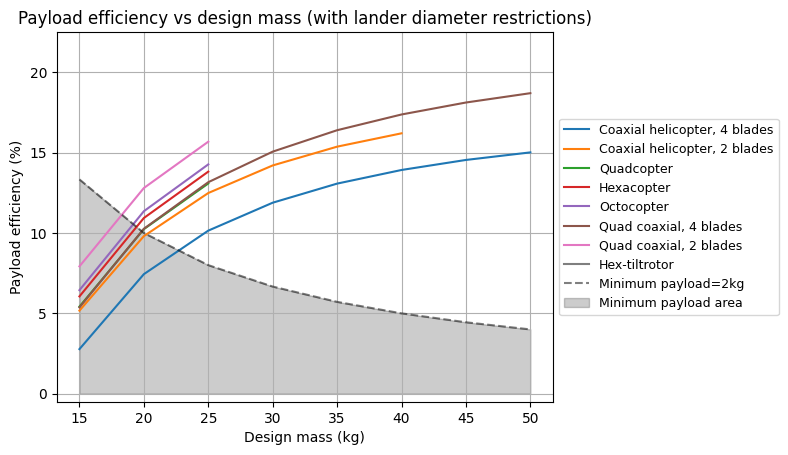

In [6]:
plt.figure()
for aircraft in aircrafts:
    design_masses, payload_efficiences = aircraft.payload_efficiency_analysis()
    plt.plot(design_masses, np.array(payload_efficiences)*100, label=aircraft.name)
design_masses = [15, 20, 25, 30, 35, 40, 45, 50]
payload_line = [100*2/design_mass for design_mass in design_masses]
plt.plot(design_masses, payload_line, linestyle='--', color='black', alpha=0.5, label="Minimum payload=2kg")
plt.fill_between(design_masses, payload_line, color='black', alpha=0.2, label="Minimum payload area")
plt.title(f"Payload efficiency vs design mass (with lander diameter restrictions)")
plt.xlabel("Design mass (kg)")
plt.ylabel("Payload efficiency (%)")
plt.grid(True)
plt.legend(loc="center left", fontsize=9, bbox_to_anchor=[1,0.5])
plt.ylim([-0.5, 22.5])
plt.show()

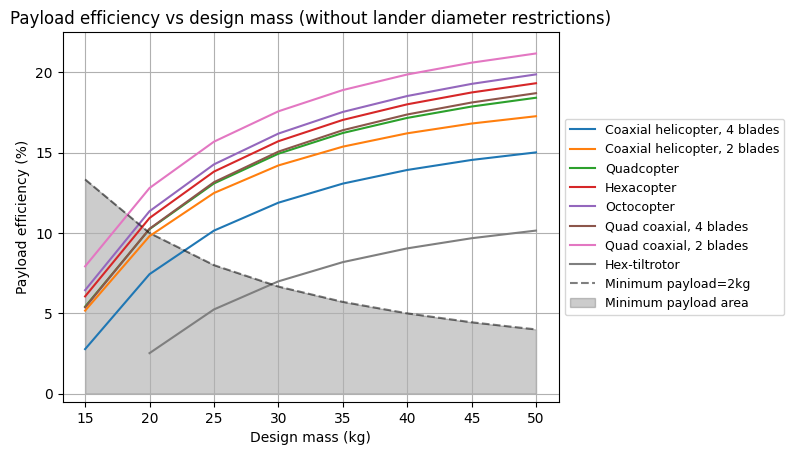

In [7]:
design_constraints.MAX_DIAMETER = 1000
plt.figure()
for aircraft in aircrafts:
    design_masses, payload_efficiences = aircraft.payload_efficiency_analysis()
    plt.plot(design_masses, np.array(payload_efficiences)*100, label=aircraft.name)
design_masses = [15, 20, 25, 30, 35, 40, 45, 50]
payload_line = [100*2/design_mass for design_mass in design_masses]
plt.plot(design_masses, payload_line, linestyle='--', color='black', alpha=0.5, label="Minimum payload=2kg")
plt.fill_between(design_masses, payload_line, color='black', alpha=0.2, label="Minimum payload area")
plt.title(f"Payload efficiency vs design mass (without lander diameter restrictions)")
plt.xlabel("Design mass (kg)")
plt.ylabel("Payload efficiency (%)")
plt.grid(True)
plt.legend(loc="center left", fontsize=9, bbox_to_anchor=[1,0.5])
plt.ylim([-0.5, 22.5])
plt.show()

### Payload vs hover/range benefits tradeoff

- fix design_mass (maybe at MASS_LIMIT, maybe at maximum payload efficiency) 
- decrease the proportion of payload for sampling and move into battery to provide more energy/power
- back calculate HOVER_TIME or FORWARD_FLIGHT_RANGE from total_power

Assumption:
- for the purpose of this ignoring the climb/descent power

Purpose:
- helpful to explore how incorrect assumption of lander accuracy could be overcome

[13310.096055446498, 10886.340537699694, 8462.585019952892, 6038.829502206092, 4402.599395613942]
[795.6528535427396, 650.7652444712729, 505.8776353998062, 360.9900263283396, 263.1792255693278]


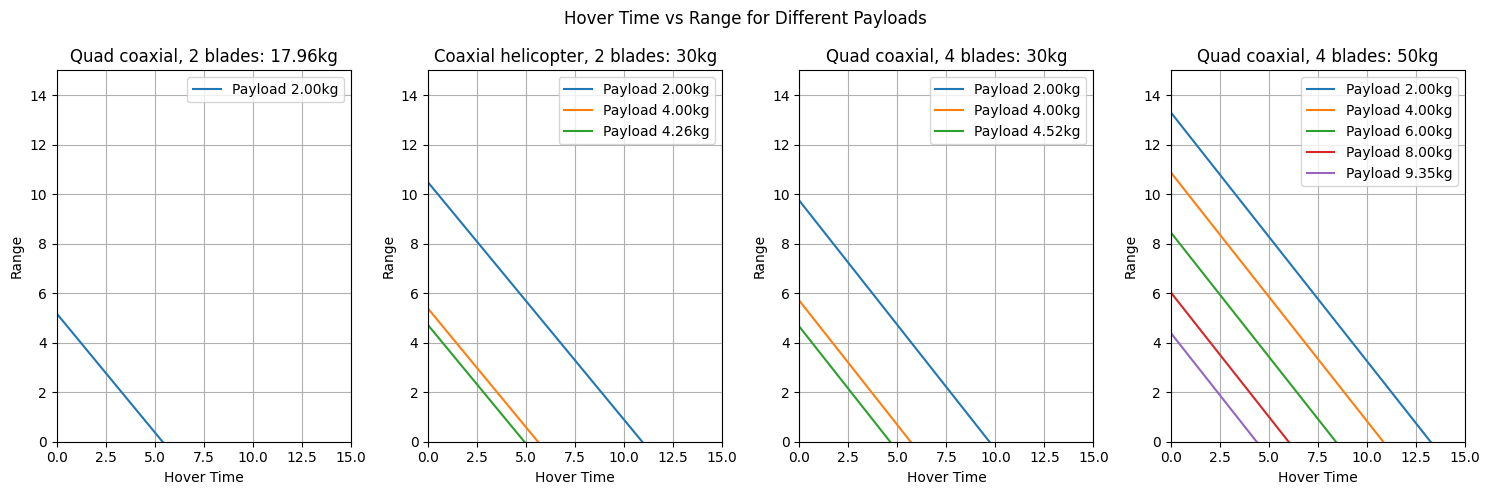

In [9]:
MIN_PAYLOAD = 2
quad_coaxial2_min_mass = 17.96
elbow_design_mass = 30
max_design_mass = 50

fig = plt.figure(figsize=(15,5))
plt.suptitle("Hover Time vs Range for Different Payloads")
valid_payloads, hover_times, ranges = quad_coaxial2.trade_payload_for_battery(quad_coaxial2_min_mass, MIN_PAYLOAD)
colours = ["blue", ]
for payload, rng, hover_time in zip(valid_payloads, ranges, hover_times):
    plt.subplot(1,4,1)
    plt.plot([0, hover_time/60], [rng/1000, 0], label=f"Payload {payload:.2f}kg")
    break
plt.xlabel('Hover Time')
plt.ylabel('Range')
plt.title(f'{quad_coaxial2.name}: {quad_coaxial2_min_mass}kg')
plt.legend()
plt.grid(True)
plt.xlim(0, 15)
plt.ylim(0, 15)

valid_payloads, hover_times, ranges = coaxial2.trade_payload_for_battery(elbow_design_mass, MIN_PAYLOAD)
for payload, rng, hover_time in zip(valid_payloads, ranges, hover_times):
    plt.subplot(1,4,2)
    plt.plot([0, hover_time/60], [rng/1000, 0], label=f"Payload {payload:.2f}kg")
plt.xlabel('Hover Time')
plt.ylabel('Range')
plt.title(f'{coaxial2.name}: {elbow_design_mass}kg')
plt.legend()
plt.grid(True) 
plt.xlim(0, 15)
plt.ylim(0, 15)

valid_payloads, hover_times, ranges = quad_coaxial4.trade_payload_for_battery(elbow_design_mass, MIN_PAYLOAD)
for payload, rng, hover_time in zip(valid_payloads, ranges, hover_times):
    plt.subplot(1,4,3)
    plt.plot([0, hover_time/60], [rng/1000, 0], label=f"Payload {payload:.2f}kg")
plt.xlabel('Hover Time')
plt.ylabel('Range')
plt.title(f'{quad_coaxial4.name}: {elbow_design_mass}kg')
plt.legend()
plt.grid(True) 
plt.xlim(0, 15)
plt.ylim(0, 15)

valid_payloads, hover_times, ranges = quad_coaxial4.trade_payload_for_battery(max_design_mass, MIN_PAYLOAD)
print(ranges)
print(hover_times)
for payload, rng, hover_time in zip(valid_payloads, ranges, hover_times):
    if payload == 10:
        continue
    plt.subplot(1,4,4)
    plt.plot([0, hover_time/60], [rng/1000, 0], label=f"Payload {payload:.2f}kg")
plt.xlabel('Hover Time')
plt.ylabel('Range')
plt.title(f'{quad_coaxial4.name}: {max_design_mass}kg')
plt.legend()
plt.grid(True) 
plt.xlim(0, 15)
plt.ylim(0, 15)

plt.tight_layout()
plt.show()

    

## Effects of inaccuracies in mass estimations

### Fixed electronics mass tradeoff

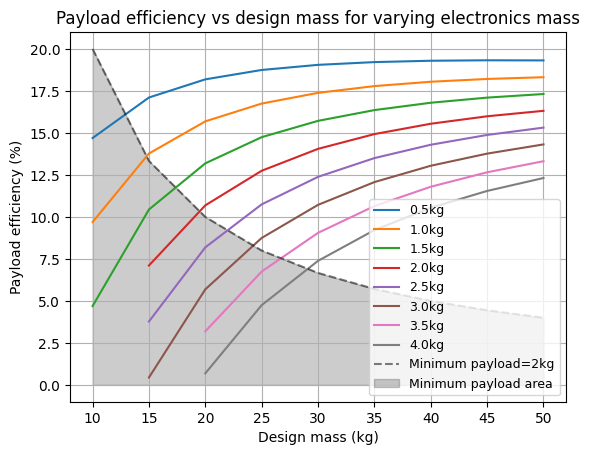

In [10]:
plt.figure()
electronics_masses = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
design_constraints.MAX_DIAMETER = MAX_DIAMETER
for electronics_mass in electronics_masses:
    design_assumptions.ELECTRONICS_MASS = electronics_mass
    coaxial = CoaxialRotorcraft("Coaxial helicopter", 2, 4, mission_scenario, design_constraints, design_assumptions)
    design_masses, payload_efficiences = coaxial.payload_efficiency_analysis()
    plt.plot(design_masses, np.array(payload_efficiences)*100, label=f"{electronics_mass:.1f}kg")
design_masses = [10,15,20,25,30,35,40,45,50]
payload_line = [100*2/design_mass for design_mass in design_masses]
plt.plot(design_masses, payload_line, linestyle='--', color='black', alpha=0.5, label="Minimum payload=2kg")
plt.fill_between(design_masses, payload_line, color='black', alpha=0.2, label="Minimum payload area")
plt.title(f"Payload efficiency vs design mass for varying electronics mass")
plt.xlabel("Design mass (kg)")
plt.ylabel("Payload efficiency (%)")
plt.grid(True)
plt.legend(fontsize=9)
plt.show()

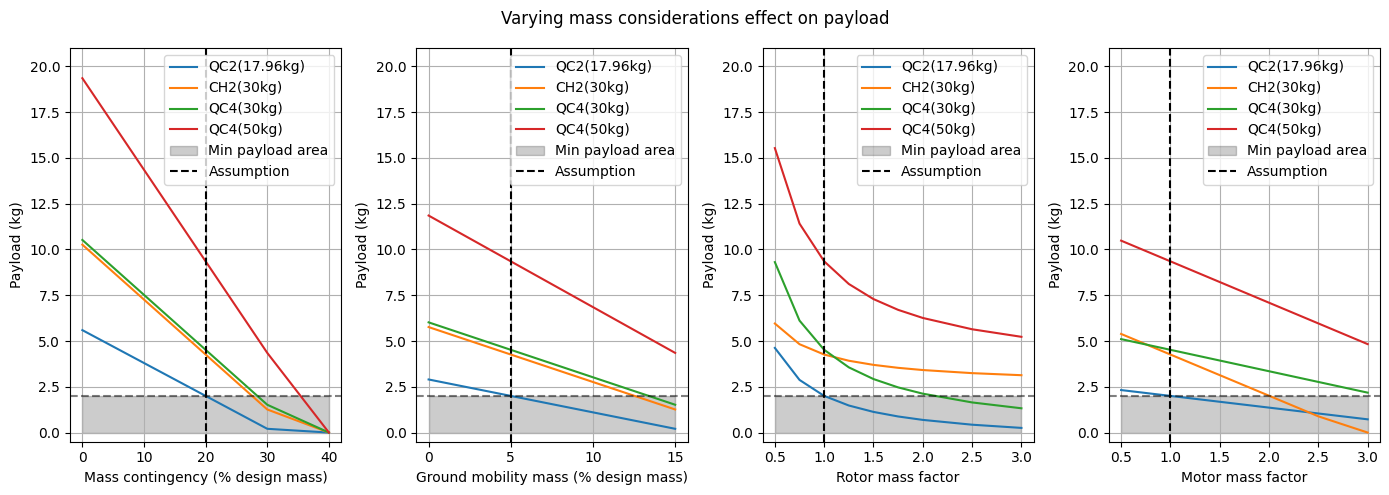

In [13]:


fig, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(14,5))
design_mass = 50
MAX_DIAMETER = 1000
contingencies = [0, 0.1, 0.2, 0.3, 0.4]
quad_coaxial2_min_mass = 17.96
elbow_design_mass = 30
max_design_mass = 50
coaxial2 = CoaxialRotorcraft("CH2(30kg)", 2, 2, mission_scenario, design_constraints, design_assumptions)
quad_coaxial2 = CoaxialRotorcraft(f"QC2({quad_coaxial2_min_mass:.2f}kg)", 8, 2, mission_scenario, design_constraints, design_assumptions)
quad_coaxial4 = CoaxialRotorcraft("QC4(30kg)", 8, 4, mission_scenario, design_constraints, design_assumptions)
quad_coaxial4_max = CoaxialRotorcraft("QC4(50kg)", 8, 4, mission_scenario, design_constraints, design_assumptions)
aircrafts = [quad_coaxial2, coaxial2, quad_coaxial4, quad_coaxial4_max]
masses = [quad_coaxial2_min_mass, elbow_design_mass, elbow_design_mass, max_design_mass]


design_constraints = DesignConstraints(mass_limit=MASS_LIMIT, max_diameter=MAX_DIAMETER)
design_assumptions = DesignAssumptions()
payloads_data = {aircraft.name: [] for aircraft in aircrafts}
for contingency in contingencies:
    design_constraints.CONTINGENCY_WEIGHT_FACTOR = contingency
    coaxial2 = CoaxialRotorcraft("CH2(30kg)", 2, 2, mission_scenario, design_constraints, design_assumptions)
    quad_coaxial2 = CoaxialRotorcraft(f"QC2({quad_coaxial2_min_mass:.2f}kg)", 8, 2, mission_scenario, design_constraints, design_assumptions)
    quad_coaxial4 = CoaxialRotorcraft("QC4(30kg)", 8, 4, mission_scenario, design_constraints, design_assumptions)
    quad_coaxial4_max = CoaxialRotorcraft("QC4(50kg)", 8, 4, mission_scenario, design_constraints, design_assumptions)
    aircrafts = [quad_coaxial2, coaxial2, quad_coaxial4, quad_coaxial4_max]
    payloads = []
    for design_mass, aircraft in zip(masses, aircrafts):
        try:
            payload = aircraft.calc_and_verify_initial_design(design_mass)
        except ValueError:
            payload = 0
        payloads.append(payload)
    for i, payload in enumerate(payloads):
        payloads_data[aircrafts[i].name].append(payload)
for name, payloads in payloads_data.items():
    ax1.plot(np.array(contingencies)*100, payloads, label=f"{name}")
ax1.axhline(y=2, color='black', linestyle='--', alpha=0.5)
ax1.fill_between(np.array(contingencies)*100, 2, color='black', alpha=0.2, label="Min payload area")
ax1.axvline(x=20, color='black', linestyle='--', label="Assumption")
ax1.set_xlabel("Mass contingency (% design mass)")
ax1.set_ylabel("Payload (kg)")
ax1.grid(True)
ax1.legend()

design_constraints = DesignConstraints(mass_limit=MASS_LIMIT, max_diameter=MAX_DIAMETER)
design_assumptions = DesignAssumptions()
gm_props = [0, 0.01, 0.02, 0.05, 0.08, 0.1, 0.15]
payloads_data = {aircraft.name: [] for aircraft in aircrafts}
for gm_prop in gm_props:
    design_assumptions.GROUND_MOBILITY_MASS_PROPORTION = gm_prop
    coaxial2 = CoaxialRotorcraft("CH2(30kg)", 2, 2, mission_scenario, design_constraints, design_assumptions)
    quad_coaxial2 = CoaxialRotorcraft(f"QC2({quad_coaxial2_min_mass:.2f}kg)", 8, 2, mission_scenario, design_constraints, design_assumptions)
    quad_coaxial4 = CoaxialRotorcraft("QC4(30kg)", 8, 4, mission_scenario, design_constraints, design_assumptions)
    quad_coaxial4_max = CoaxialRotorcraft("QC4(50kg)", 8, 4, mission_scenario, design_constraints, design_assumptions)
    aircrafts = [quad_coaxial2, coaxial2, quad_coaxial4, quad_coaxial4_max]
    payloads = []
    for design_mass, aircraft in zip(masses, aircrafts):
        try:
            payload = aircraft.calc_and_verify_initial_design(design_mass)
        except ValueError:
            payload = 0
        payloads.append(payload)
    for i, payload in enumerate(payloads):
        payloads_data[aircrafts[i].name].append(payload)
for name, payloads in payloads_data.items():
    ax2.plot(np.array(gm_props)*100, payloads, label=f"{name}")
ax2.axhline(y=2, color='black', linestyle='--', alpha=0.5)
ax2.fill_between(np.array(gm_props)*100, 2, color='black', alpha=0.2, label="Min payload area")
ax2.axvline(x=5, color='black', linestyle='--', label="Assumption")
ax2.set_xlabel("Ground mobility mass (% design mass)")
ax2.set_ylabel("Payload (kg)")
ax2.grid(True)
ax2.legend()

design_assumptions = DesignAssumptions()
rotor_mass_factors = [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.5, 3]
payloads_data = {aircraft.name: [] for aircraft in aircrafts}
for rotor_mass_factor in rotor_mass_factors:
    design_assumptions.ROTOR_MASS_FACTOR = rotor_mass_factor
    coaxial2 = CoaxialRotorcraft("CH2(30kg)", 2, 2, mission_scenario, design_constraints, design_assumptions)
    quad_coaxial2 = CoaxialRotorcraft(f"QC2({quad_coaxial2_min_mass:.2f}kg)", 8, 2, mission_scenario, design_constraints, design_assumptions)
    quad_coaxial4 = CoaxialRotorcraft("QC4(30kg)", 8, 4, mission_scenario, design_constraints, design_assumptions)
    quad_coaxial4_max = CoaxialRotorcraft("QC4(50kg)", 8, 4, mission_scenario, design_constraints, design_assumptions)
    aircrafts = [quad_coaxial2, coaxial2, quad_coaxial4, quad_coaxial4_max]
    payloads = []
    for design_mass, aircraft in zip(masses, aircrafts):
        try:
            payload = aircraft.calc_and_verify_initial_design(design_mass)
        except ValueError:
            payload = 0
        payloads.append(payload)
    for i, payload in enumerate(payloads):
        payloads_data[aircrafts[i].name].append(payload)
for name, payloads in payloads_data.items():
    ax3.plot(rotor_mass_factors, payloads, label=f"{name}")
ax3.axhline(y=2, color='black', linestyle='--', alpha=0.5)
ax3.fill_between(rotor_mass_factors, 2, color='black', alpha=0.2, label="Min payload area")
ax3.axvline(x=1.0, color='black', linestyle='--', label="Assumption")
ax3.set_xlabel("Rotor mass factor")
ax3.set_ylabel("Payload (kg)")
ax3.grid(True)
ax3.legend()

design_assumptions = DesignAssumptions()
motor_mass_factors = [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.5, 3]
payloads_data = {aircraft.name: [] for aircraft in aircrafts}
for motor_mass_factor in motor_mass_factors:
    design_assumptions.MOTOR_MASS_FACTOR = motor_mass_factor
    coaxial2 = CoaxialRotorcraft("CH2(30kg)", 2, 2, mission_scenario, design_constraints, design_assumptions)
    quad_coaxial2 = CoaxialRotorcraft(f"QC2({quad_coaxial2_min_mass:.2f}kg)", 8, 2, mission_scenario, design_constraints, design_assumptions)
    quad_coaxial4 = CoaxialRotorcraft("QC4(30kg)", 8, 4, mission_scenario, design_constraints, design_assumptions)
    quad_coaxial4_max = CoaxialRotorcraft("QC4(50kg)", 8, 4, mission_scenario, design_constraints, design_assumptions)
    aircrafts = [quad_coaxial2, coaxial2, quad_coaxial4, quad_coaxial4_max]
    payloads = []
    for design_mass, aircraft in zip(masses, aircrafts):
        try:
            payload = aircraft.calc_and_verify_initial_design(design_mass)
        except ValueError:
            payload = 0
        payloads.append(payload)
    for i, payload in enumerate(payloads):
        payloads_data[aircrafts[i].name].append(payload)
for name, payloads in payloads_data.items():
    ax4.plot(motor_mass_factors, payloads, label=f"{name}")
ax4.axhline(y=2, color='black', linestyle='--', alpha=0.5)
ax4.fill_between(motor_mass_factors, 2, color='black', alpha=0.2, label="Min payload area")
ax4.axvline(x=1.0, color='black', linestyle='--', label="Assumption")
ax4.set_xlabel("Motor mass factor")
ax4.set_ylabel("Payload (kg)")
ax4.grid(True)
ax4.legend()

ax1.set_ylim(-0.5,21)
ax2.set_ylim(-0.5,21)
ax3.set_ylim(-0.5,21)
ax4.set_ylim(-0.5,21)
plt.suptitle("Varying mass considerations effect on payload")
plt.tight_layout()
plt.show()


## Number of blade effects

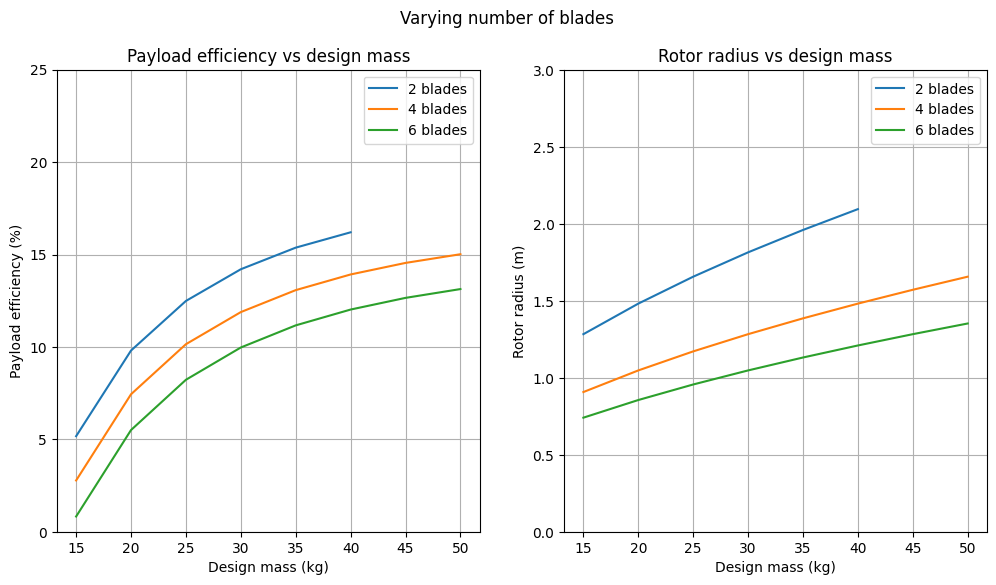

In [14]:
design_constraints = DesignConstraints(mass_limit=MASS_LIMIT, max_diameter=4.35)
design_assumptions = DesignAssumptions()

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12,6))
fig.suptitle("Varying number of blades")
blades = [2, 4, 6]
for no_blades in blades:
    coaxial = CoaxialRotorcraft("Coaxial helicopter", 2, no_blades, mission_scenario, design_constraints, design_assumptions)
    design_masses, payload_efficiences, rotor_radiuses = coaxial.number_of_blades_analysis()
    ax1.plot(design_masses, np.array(payload_efficiences)*100, label=f"{no_blades} blades")
    ax2.plot(design_masses, np.array(rotor_radiuses), label=f"{no_blades} blades")
ax1.set_title(f"Payload efficiency vs design mass")
ax1.set_xlabel("Design mass (kg)")
ax1.set_ylabel("Payload efficiency (%)")
ax1.grid(True)
ax1.legend()
ax1.set_ylim(0, 25)
ax2.set_title(f"Rotor radius vs design mass")
ax2.set_xlabel("Design mass (kg)")
ax2.set_ylabel("Rotor radius (m)")
ax2.grid(True)
ax2.legend()
ax2.set_ylim(0, 3)
plt.show()

## Varying hover time effect on payload

In [21]:
[print(time, prop) for time, prop in zip(hover_times, hover_props)]

0.0 0.0
30.0 0.36946523680883375
60.0 0.5387727206528947
90.0 0.6359076341950708
120.0 0.6989106633539345
150.0 0.7430836050039904
180.0 0.7757707348486397
210.0 0.8009364413325474
240.0 0.8209089203242951
270.0 0.8371453417341373
300.0 0.8506043457911054
330.0 0.8619424423008819
360.0 0.8716243437420137


[None, None, None, None, None, None, None, None, None, None, None, None, None]

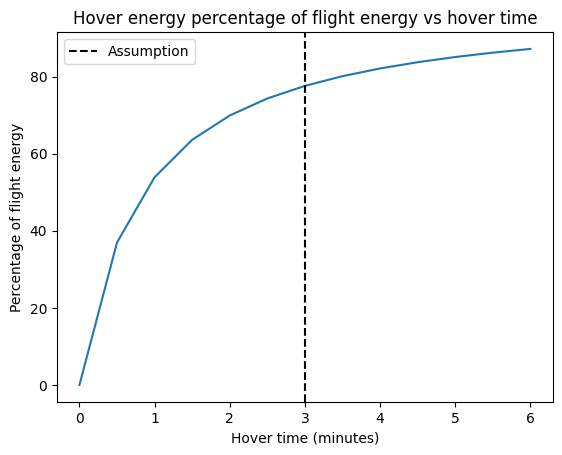

In [15]:
mission_scenario = FlightMissionScenario(
        hover_time=3*60, forward_flight_distance=600, climb_height=50, 
        climb_rate=10, descent_rate=10)
design_constraints = DesignConstraints(mass_limit=MASS_LIMIT, max_diameter=MAX_DIAMETER)
design_assumptions = DesignAssumptions()
design_mass_max = 50
hover_times = np.arange(0, 6.5, 0.5) * 60
hover_props = []
for hover_time in hover_times:
        mission_scenario = FlightMissionScenario(
                hover_time=hover_time, forward_flight_distance=600, climb_height=50, 
                climb_rate=10, descent_rate=10)
        quad_coaxial4_max = CoaxialRotorcraft("QC4(50kg)", 8, 4, mission_scenario, design_constraints, design_assumptions)
        quad_coaxial4_max.calc_and_verify_initial_design(design_mass_max)
        # quad_coaxial4_max.print_mission_energy_breakdown()
        hover_props.append(quad_coaxial4_max.get_hover_proportion())
plt.plot(hover_times/60, np.array(hover_props)*100)
plt.axvline(x=3, color='black', linestyle='--', label="Assumption")
plt.xlabel("Hover time (minutes)")
plt.ylabel("Percentage of flight energy")
plt.title("Hover energy percentage of flight energy vs hover time")
plt.legend()
plt.show()

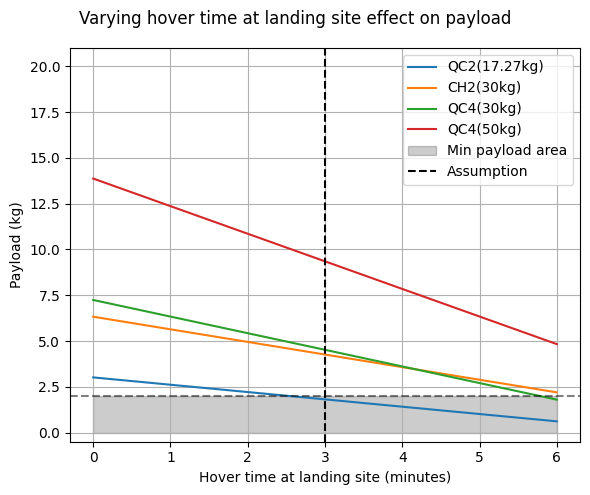

In [17]:


fig, ax1 = plt.subplots(1, 1, figsize=(6,5))
design_mass = 50
MAX_DIAMETER = 1000
quad_coaxial2_min_mass = 17.27
elbow_design_mass = 30
max_design_mass = 50
design_constraints = DesignConstraints(mass_limit=MASS_LIMIT, max_diameter=MAX_DIAMETER)
design_assumptions = DesignAssumptions()

coaxial2 = CoaxialRotorcraft("CH2(30kg)", 2, 2, mission_scenario, design_constraints, design_assumptions)
quad_coaxial2 = CoaxialRotorcraft(f"QC2({quad_coaxial2_min_mass:.2f}kg)", 8, 2, mission_scenario, design_constraints, design_assumptions)
quad_coaxial4 = CoaxialRotorcraft("QC4(30kg)", 8, 4, mission_scenario, design_constraints, design_assumptions)
quad_coaxial4_max = CoaxialRotorcraft("QC4(50kg)", 8, 4, mission_scenario, design_constraints, design_assumptions)
aircrafts = [quad_coaxial2, coaxial2, quad_coaxial4, quad_coaxial4_max]
masses = [quad_coaxial2_min_mass, elbow_design_mass, elbow_design_mass, max_design_mass]

payloads_data = {aircraft.name: [] for aircraft in aircrafts}
hover_times = np.arange(0, 6.5, 0.5) * 60
for hover_time in hover_times:
    mission_scenario.HOVER_TIME = hover_time
    coaxial2 = CoaxialRotorcraft("CH2(30kg)", 2, 2, mission_scenario, design_constraints, design_assumptions)
    quad_coaxial2 = CoaxialRotorcraft(f"QC2({quad_coaxial2_min_mass:.2f}kg)", 8, 2, mission_scenario, design_constraints, design_assumptions)
    quad_coaxial4 = CoaxialRotorcraft("QC4(30kg)", 8, 4, mission_scenario, design_constraints, design_assumptions)
    quad_coaxial4_max = CoaxialRotorcraft("QC4(50kg)", 8, 4, mission_scenario, design_constraints, design_assumptions)
    aircrafts = [quad_coaxial2, coaxial2, quad_coaxial4, quad_coaxial4_max]
    payloads = []
    for design_mass, aircraft in zip(masses, aircrafts):
        try:
            payload = aircraft.calc_and_verify_initial_design(design_mass)
        except ValueError:
            payload = 0
        payloads.append(payload)
    for i, payload in enumerate(payloads):
        payloads_data[aircrafts[i].name].append(payload)
for name, payloads in payloads_data.items():
    ax1.plot(hover_times/60, payloads, label=f"{name}")
ax1.axhline(y=2, color='black', linestyle='--', alpha=0.5)
ax1.fill_between(hover_times/60, 2, color='black', alpha=0.2, label="Min payload area")
ax1.axvline(x=3, color='black', linestyle='--', label="Assumption")
ax1.set_xlabel("Hover time at landing site (minutes)")
ax1.set_ylabel("Payload (kg)")
ax1.grid(True)
ax1.legend()

# ax1.set_xlim(-0.5, 5.5)
ax1.set_ylim(-0.5,21)
plt.suptitle("Varying hover time at landing site effect on payload")
plt.tight_layout()
plt.show()


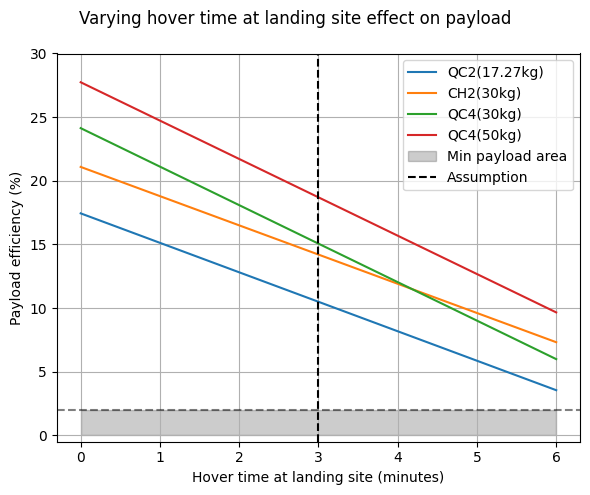

In [25]:


fig, ax1 = plt.subplots(1, 1, figsize=(6,5))
design_mass = 50
MAX_DIAMETER = 1000
quad_coaxial2_min_mass = 17.27
elbow_design_mass = 30
max_design_mass = 50
design_constraints = DesignConstraints(mass_limit=MASS_LIMIT, max_diameter=MAX_DIAMETER)
design_assumptions = DesignAssumptions()

coaxial2 = CoaxialRotorcraft("CH2(30kg)", 2, 2, mission_scenario, design_constraints, design_assumptions)
quad_coaxial2 = CoaxialRotorcraft(f"QC2({quad_coaxial2_min_mass:.2f}kg)", 8, 2, mission_scenario, design_constraints, design_assumptions)
quad_coaxial4 = CoaxialRotorcraft("QC4(30kg)", 8, 4, mission_scenario, design_constraints, design_assumptions)
quad_coaxial4_max = CoaxialRotorcraft("QC4(50kg)", 8, 4, mission_scenario, design_constraints, design_assumptions)
aircrafts = [quad_coaxial2, coaxial2, quad_coaxial4, quad_coaxial4_max]
masses = [quad_coaxial2_min_mass, elbow_design_mass, elbow_design_mass, max_design_mass]

payloads_data = {aircraft.name: [] for aircraft in aircrafts}
hover_times = np.arange(0, 6.5, 0.5) * 60
for hover_time in hover_times:
    mission_scenario.HOVER_TIME = hover_time
    coaxial2 = CoaxialRotorcraft("CH2(30kg)", 2, 2, mission_scenario, design_constraints, design_assumptions)
    quad_coaxial2 = CoaxialRotorcraft(f"QC2({quad_coaxial2_min_mass:.2f}kg)", 8, 2, mission_scenario, design_constraints, design_assumptions)
    quad_coaxial4 = CoaxialRotorcraft("QC4(30kg)", 8, 4, mission_scenario, design_constraints, design_assumptions)
    quad_coaxial4_max = CoaxialRotorcraft("QC4(50kg)", 8, 4, mission_scenario, design_constraints, design_assumptions)
    aircrafts = [quad_coaxial2, coaxial2, quad_coaxial4, quad_coaxial4_max]
    payloads = []
    for design_mass, aircraft in zip(masses, aircrafts):
        try:
            payload = aircraft.calc_and_verify_initial_design(design_mass)
        except ValueError:
            payload = 0
        payloads.append(payload/design_mass)
    for i, payload in enumerate(payloads):
        payloads_data[aircrafts[i].name].append(payload)
for name, payloads in payloads_data.items():
    ax1.plot(hover_times/60, np.array(payloads)*100, label=f"{name}")
ax1.axhline(y=2, color='black', linestyle='--', alpha=0.5)
ax1.fill_between(hover_times/60, 2, color='black', alpha=0.2, label="Min payload area")
ax1.axvline(x=3, color='black', linestyle='--', label="Assumption")
ax1.set_xlabel("Hover time at landing site (minutes)")
ax1.set_ylabel("Payload efficiency (%)")
ax1.grid(True)
ax1.legend()

# ax1.set_xlim(-0.5, 5.5)
ax1.set_ylim(-0.5,30)
plt.suptitle("Varying hover time at landing site effect on payload")
plt.tight_layout()
plt.show()


## Design comparison

Not using this as logging seems to be bugging

In [13]:
# MASS_LIMIT = 50
# design_constraints = DesignConstraints(mass_limit=MASS_LIMIT, max_diameter=4.35)
# design_assumptions = DesignAssumptions()
# coaxial = CoaxialRotorcraft("Coaxial helicopter", 2, 4, mission_scenario, design_constraints, design_assumptions, logging.INFO)
# quad_coaxial = CoaxialRotorcraft("Quad coaxial", 8, 4, mission_scenario, design_constraints, design_assumptions, logging.INFO)

In [ ]:
# design_mass = 30
# payload = coaxial.calc_and_verify_initial_design(design_mass)
# # print(f"{coaxial.name}: {payload:.2f}kg. Diameter: {coaxial.total_diameter:.2f}m")

# payload = quad_coaxial.calc_and_verify_initial_design(design_mass)
# # print(f"{quad_coaxial.name}: {payload:.2f}kg. Diameter: {quad_coaxial.total_diameter:.2f}m")